In [3]:
import numpy as np
import scipy as sp
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from LIFTrainingGPU import LIFTrainingGPU
from LIFTrainingGPU import create_default_params_LIF

In [5]:
p = create_default_params_LIF()
p['net_size'] = 1000
p['total_time'] = 2000
p['runtime'] = 2000
p['training_loops'] = 100
p['stim_off'] = 50
targnet = LIFTrainingGPU(p)

In [6]:
def gen_sine_targets(N, T, dt): 
    
    timesteps = int(T/dt)
    targets = np.zeros((N, timesteps))
    for i in range(N):
        amp = sp.stats.uniform.rvs() + 0.5
        t0 = sp.stats.uniform.rvs() * 2000
        t1 = sp.stats.uniform.rvs() * 1500 + 500
        x = np.linspace(0, T, num = timesteps)
        targets[i] = amp * np.sin(2 * np.pi * (x - t0)/t1)
    fout = np.zeros(timesteps)
    return targets, fout

### first creation of saved network

In [ ]:
stimr = targnet.gen_rand_stim(p) 

In [ ]:
targ, fout = gen_sine_targets(targnet.N, targnet.T, targnet.dt)

In [ ]:
targnet.trainGPU_LIF(stimr, targ, fout)

In [ ]:
voltage, slow, fast = targnet.run_LIF(stimr)
Jslow = np.dot(targnet.Js, slow)

n_plot = 10
T = targnet.T
dt = targnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(stimr[i])
    axs[i].plot(Jslow[i])
    axs[i].plot(targ[i])
axs[0].set_title("Behavior after training")

In [ ]:
t = np.linspace(0, 499, 500)
tau = 100
alpha = (t/tau * np.exp(-t/tau))

In [ ]:
plt.plot(alpha)
np.sum(alpha)

In [ ]:
spks = voltage > -55
plt.plot(spks[1])

In [ ]:
plt.plot(np.convolve(spks[1], alpha)[0:2000])

In [ ]:
convtargs = np.zeros((1000, 2499))

In [ ]:
for i in range(len(convtargs)):
    convtargs[i, :] = np.convolve(spks[i], alpha)

In [ ]:
np.save("Js", targnet.Js)
np.save("Jf", targnet.Jf)
np.save("W_out", targnet.W_out)
np.save("rand_stim", stimr)
np.save("sine_targs", targ)
np.save("fout", fout)
np.save("convtargs", convtargs)

### training new networks

In [7]:
stargs, sfout = gen_sine_targets(p['net_size'], p['total_time'], p['dt'])
sfout = np.array([sfout])

In [8]:
ctargs = np.load("convtargs.npy")
fout = np.load("fout.npy")
fout = np.array([fout])
np.shape(fout)

(1, 2000)

In [9]:
arrs = 100

In [10]:
Js_arr = np.zeros((1000, 1000, arrs))
slows = np.zeros((1000, 2000, arrs))
for i in range(arrs): 
    if i % 10 == 0:
        print(i)
    net = LIFTrainingGPU(p)
    rstim = net.gen_rand_stim(p)
    net.trainGPU_LIF(rstim, stargs, sfout)

    voltage, slow, fast = net.run_LIF(rstim)
    Jslow = np.dot(net.Js, slow)

    Js_arr[:, :, i] = net.Js
    slows[:, :, i] = Jslow

0


Text(0, 0.5, 'Imaginary axis')

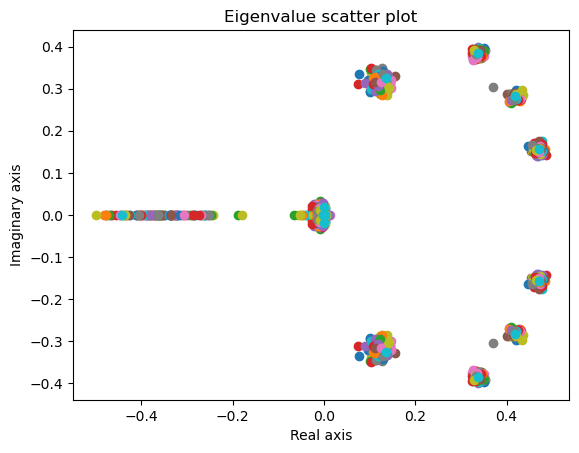

In [ ]:
norms = [0]*arrs

for i in range(arrs):
    eigs = np.linalg.eigvals(Js_arr[:, :, i])
    eigs.sort()
    s = np.real(eigs)
    js = Js_arr[:, :, i]
    norms[i] = np.linalg.norm(js)
    plt.scatter(np.real(eigs), np.imag(eigs))
plt.title("Eigenvalue scatter plot")
plt.xlabel("Real axis")
plt.ylabel("Imaginary axis")

In [ ]:
n_plot = 5
T = targnet.T
dt = targnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for j in range(n_plot):
    for i in range(arrs):
        axs[j].plot(slows[j, :, i]) 
    axs[j].plot(stargs[j][0:2000])

axs[0].set_title("Behavior after training")

NameError: name 'targnet' is not defined

In [ ]:
norms = [0]*arrs
for i in range(arrs):
    js = Js_arr[:, :, i]
    norms[i] = np.linalg.norm(js)

print(norms)
plt.hist(norms, 40)
plt.xlim(4,8)
plt.title("Histogram of connectivity frobenius norms")
plt.xlabel("Frobenius norm")
plt.ylabel("Number of matrices")

NameError: name 'arrs' is not defined

In [ ]:
Js = np.load("Js.npy")
eigso = np.linalg.eigvals(Js)
plt.scatter(np.real(eigso), np.imag(eigso))

In [ ]:
m0 = max(-1*np.min(Js), np.max(Js))
plt.imshow(Js, cmap=plt.get_cmap('seismic'), vmin = -m0, vmax = m0)
plt.colorbar()
sns.clustermap(Js, cmap=plt.get_cmap('seismic'), vmin = -m0, vmax = m0, figsize = (6, 6))

In [ ]:
voltage, slow, fast = net.run_LIF(rstim)
voltage1, slow1, fast1 = net1.run_LIF(rstim1)
Jslow = np.dot(net.Js, slow)
Jslow1 = np.dot(net1.Js, slow1)

n_plot = 5
T = targnet.T
dt = targnet.dt

fig, axs = plt.subplots(n_plot, 1, figsize = (6, 12), sharex = True)
for i in range(n_plot):
    axs[i].plot(Jslow[i])
    axs[i].plot(Jslow1[i])
    axs[i].plot(ctargs[i][0:2000])
axs[0].set_title("Behavior after training")